In [4]:
import random
import json
import pathlib
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from net import UnetGenerator
from argparse import Namespace
from torchvision import datasets
from utils import ABImageDataset, ToTensorTwoIMG, Normalize, ComposeTwoIMG, SplitImage
import cv2

In [5]:
number=4
seeds=list(range(1, 6))
data_name='edges2shoes'

In [6]:
result_path = [
    pathlib.Path('/Users/yohei/MyDrive/tlab/pix2pix.pytorch/{0}/'
                 'result_{1}/result_{1}_{2}'.format(data_name, number, seed))
    for seed in seeds
]
data_path = pathlib.Path(
    '/Users/yohei/MyDrive/tlab/pix2pix.pytorch/{0}/'.format(data_name))
model_path = [i / 'model' for i in result_path]
log_path = [i / 'log.json' for i in result_path]
arg_path = [i / 'args.txt' for i in result_path]
train_data_path = data_path / 'train_data'
val_data_path = data_path / 'validation_data'

# ロスの推移

In [20]:
df = pd.read_json(log_path[0]).T
df = df.reset_index()
df.columns = ['epoch', 'train_dis_loss', 'train_gen_loss']
df['seed'] = np.full(len(df), fill_value=seeds[0])
for path, seed in zip(log_path[1:], seeds[1:]):
    hoge = pd.read_json(path).T
    hoge = hoge.reset_index()
    hoge.columns = ['epoch', 'train_dis_loss', 'train_gen_loss']
    hoge['seed'] = np.full(len(hoge), fill_value=seed)
    df = pd.concat([df, hoge], axis=0)
df_pre = df.set_index(['epoch', 'seed'])
df_pre.head()

,,train_dis_loss,train_gen_loss
epoch,seed,,
epoch_1,1,0.198569,20.560958
epoch_2,1,0.069642,20.965312
epoch_3,1,0.049281,21.524207
epoch_4,1,0.041090,22.180810
epoch_5,1,0.032094,22.484514


In [21]:
df_mean = df_pre.mean(level=0, axis=0)
df_std = df_pre.std(level=0, axis=0)
df_mean.head()

,train_dis_loss,train_gen_loss
epoch,,
epoch_1,0.210928,20.514874
epoch_2,0.070782,20.988806
epoch_3,0.051340,21.559252
epoch_4,0.040071,22.152168
epoch_5,0.035762,22.406152


In [22]:
df_std.head()

,train_dis_loss,train_gen_loss
epoch,,
epoch_1,0.009352,0.073675
epoch_2,0.001168,0.103613
epoch_3,0.002440,0.124580
epoch_4,0.001497,0.052943
epoch_5,0.002762,0.112780


In [23]:
dis_loss_mean = np.array([mean[1]['train_dis_loss'] for mean in df_mean.iterrows()])
gen_loss_mean = np.array([mean[1]['train_gen_loss'] for mean in df_mean.iterrows()])
dis_loss_std = np.array([std[1]['train_dis_loss'] for std in df_std.iterrows()])
gen_loss_std = np.array([std[1]['train_gen_loss'] for std in df_std.iterrows()])

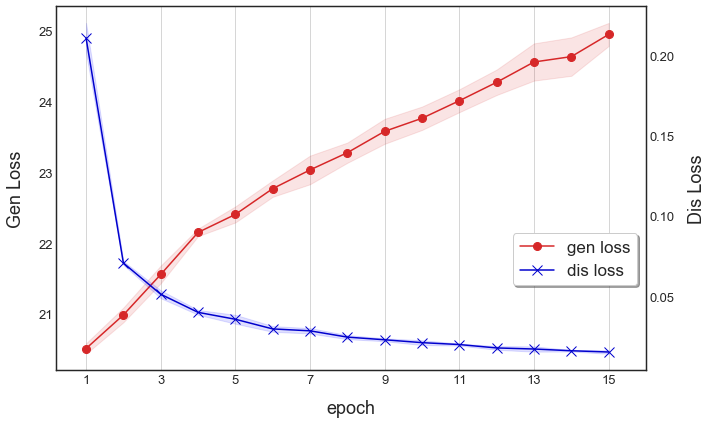

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim([-0.8, 15])
line_1 = ax.plot(
    gen_loss_mean, label='gen loss', c="tab:red", marker='o', ms=8)
ax.fill_between(
    range(15),
    gen_loss_mean + gen_loss_std,
    gen_loss_mean - gen_loss_std,
    alpha=0.12, color="tab:red")
ax.grid(axis="x")
ax2 = ax.twinx()
line_2 = ax2.plot(
    dis_loss_mean, label='dis loss', c="mediumblue", marker='x', ms=10)
ax2.fill_between(
    range(15),
    dis_loss_mean + dis_loss_std,
    dis_loss_mean - dis_loss_std,
    alpha=0.12, color="blue")
fig.legend(
    loc='upper right',
    bbox_to_anchor=(1, 0.4),
    bbox_transform=ax.transAxes,
    frameon=True,
    shadow=True,
    fontsize=17)
ax.tick_params(labelsize=13)
ax2.tick_params(labelsize=13)
ax.set_xticklabels([2 * i + 1 for i in range(-1, 8)])
ax.set_xlabel("epoch", fontsize=18, labelpad=13)
ax.set_ylabel("Gen Loss", fontsize=18, labelpad=13)
ax2.set_ylabel("Dis Loss", fontsize=18, labelpad=13)

plt.tight_layout()
fig.savefig(
    result_path[0].parent / "loss_{}.png".format(number),
    #dpi=300,
    bbox_inches='tight',
    pad_inches=0.1)

# 生成データの可視化

In [7]:
seed = 0

In [8]:
with open(arg_path[0]) as f:
    opt = eval(f.read())
print(opt)

Namespace(batch_size=4, dataset='edges2shoes', epoch=15, gpu=0, lambda_L1=100.0, mean=0.5, ndf=64, ngf=64, norm_type='batch', num_workers=4, number=4, seed=1, std=0.5, use_leaky2dc=True, val_size=16, version=False)


In [9]:
# load dataset
transform = {
    'train': ComposeTwoIMG([ToTensorTwoIMG()]),
    'val': ComposeTwoIMG([ToTensorTwoIMG()])
}
mean = [opt.mean, opt.mean, opt.mean]
std = [opt.std, opt.std, opt.std]

datasets = {
    'train':
    ABImageDataset(
        root=train_data_path,
        transform=transform['train'],
        normalizer=Normalize(mean, std),
        spliter=SplitImage(right_is_A=False)),
    'val':
    ABImageDataset(
        root=val_data_path,
        transform=transform['val'],
        val_size=opt.val_size,
        normalizer=Normalize(mean, std),
        spliter=SplitImage(right_is_A=False))
}

data_loader = {
    phase: DataLoader(
        datasets[phase],
        batch_size=len(datasets[phase]),
        shuffle=False,
        num_workers=0)
    for phase in ['train', 'val']
}

data_loader

{'train': <torch.utils.data.dataloader.DataLoader at 0x12d768898>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x12d768b38>}

## Ground Truth of Training Data

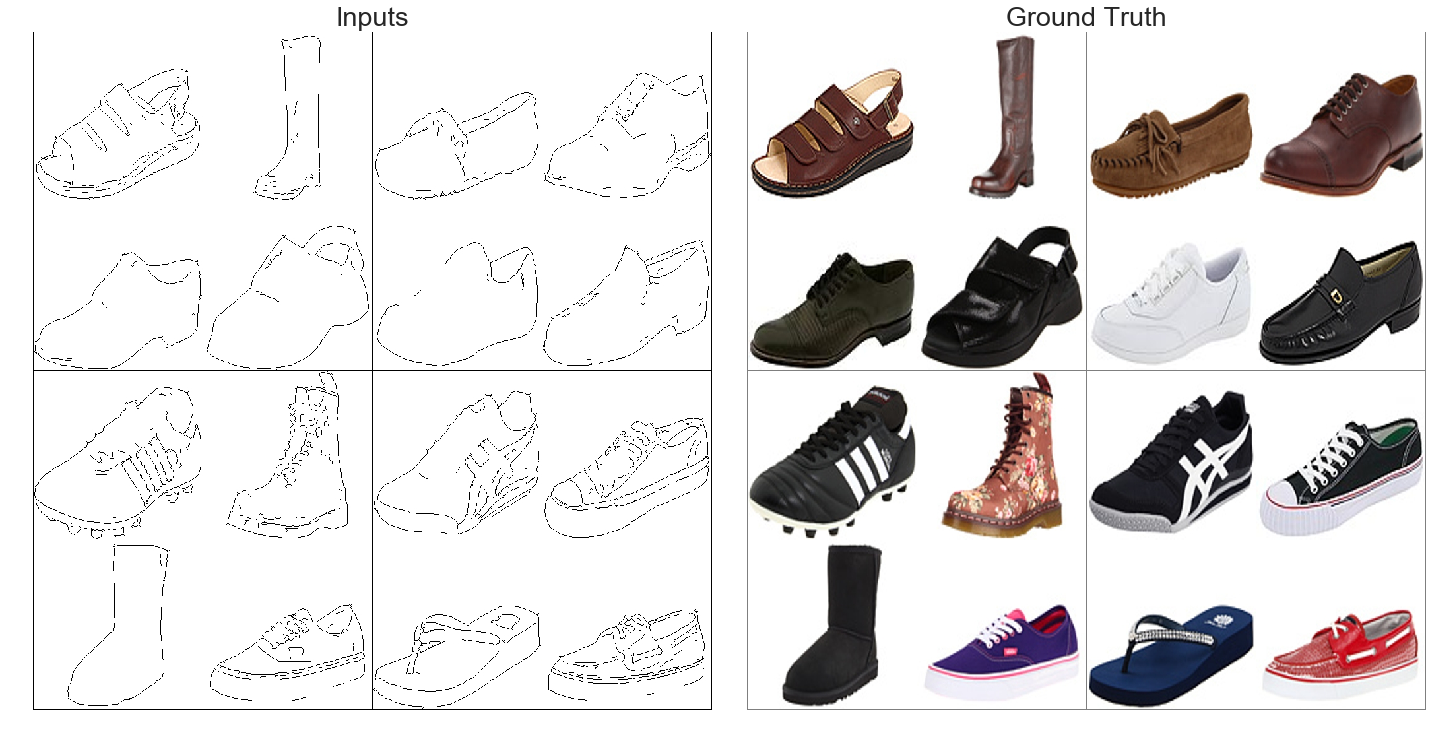

In [29]:
inputs, outputs = next(iter(data_loader['train']))
inputs = make_grid(inputs, normalize=False, nrow=4, padding=1)
outputs = make_grid(outputs, normalize=False, nrow=4, padding=1)
outputs = outputs * 0.5+0.5
fig, axes = plt.subplots(1, 2, figsize=(20, 13))
cnt = 0
for axis, images in zip(axes.flatten(), [inputs, outputs]):
    axis.imshow(images.numpy().transpose(1, 2, 0))
    axis.axis("off")
    if cnt == 0:
        axis.set_title('Inputs', fontsize=27)
        cnt+=1
    else:
        axis.set_title('Ground Truth', fontsize=27)
plt.tight_layout()
fig.savefig(
    result_path[0].parent.parent / "train_ground_truth.png".format(epoch),
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=300)

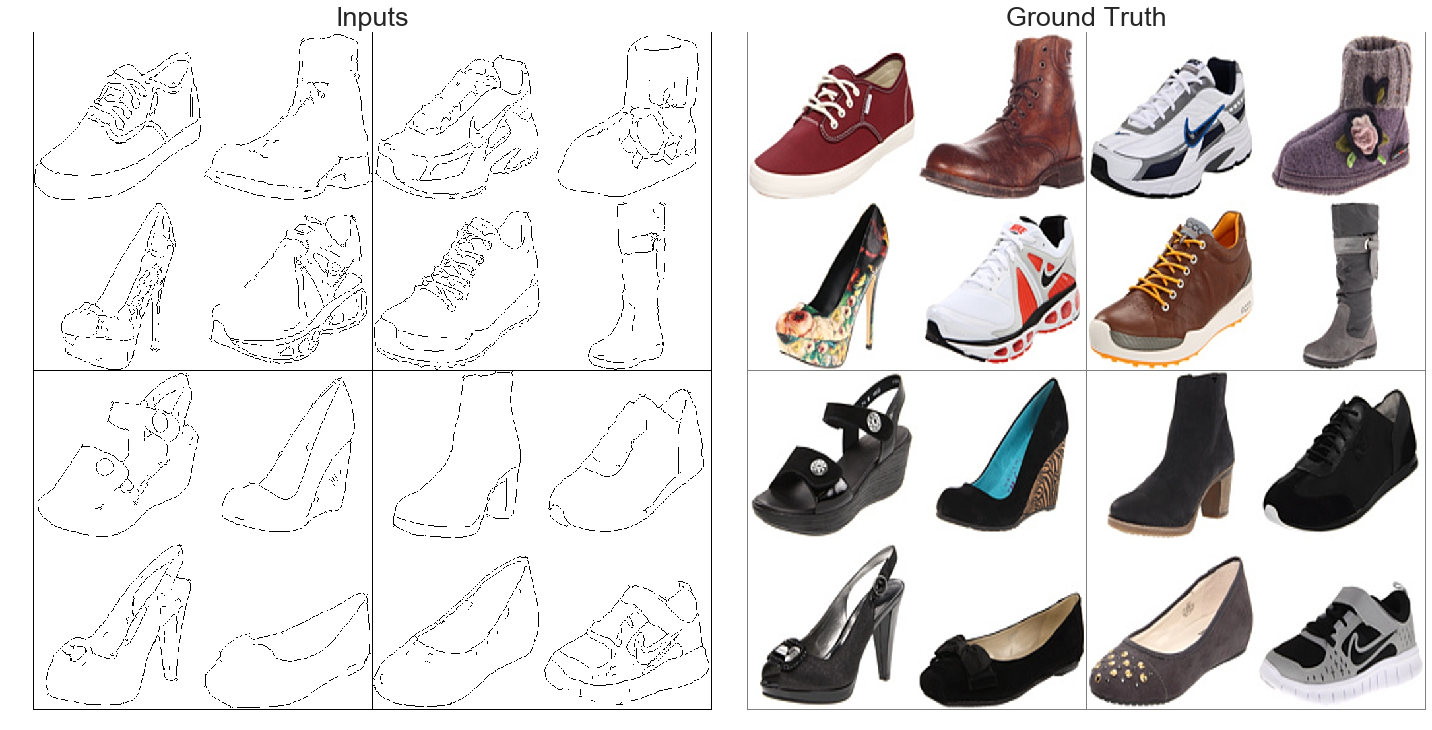

In [30]:
inputs, outputs = next(iter(data_loader['val']))
inputs = make_grid(inputs, normalize=False, nrow=4, padding=1)
outputs = make_grid(outputs, normalize=False, nrow=4, padding=1)
outputs = outputs * 0.5+0.5
fig, axes = plt.subplots(1, 2, figsize=(20, 13))
cnt = 0
for axis, images in zip(axes.flatten(), [inputs, outputs]):
    axis.imshow(images.numpy().transpose(1, 2, 0))
    axis.axis("off")
    if cnt == 0:
        axis.set_title('Inputs', fontsize=27)
        cnt+=1
    else:
        axis.set_title('Ground Truth', fontsize=27)
plt.tight_layout()
fig.savefig(
    result_path[0].parent.parent / "val_ground_truth.png".format(epoch),
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=300)

## Visualize Generating Image for Training Data

In [28]:
model_path

[PosixPath('/Users/yohei/MyDrive/tlab/pix2pix.pytorch/edges2shoes/result_6/result_6_1/model'),
 PosixPath('/Users/yohei/MyDrive/tlab/pix2pix.pytorch/edges2shoes/result_6/result_6_2/model'),
 PosixPath('/Users/yohei/MyDrive/tlab/pix2pix.pytorch/edges2shoes/result_6/result_6_3/model'),
 PosixPath('/Users/yohei/MyDrive/tlab/pix2pix.pytorch/edges2shoes/result_6/result_6_4/model'),
 PosixPath('/Users/yohei/MyDrive/tlab/pix2pix.pytorch/edges2shoes/result_6/result_6_5/model')]

In [10]:
for path in tqdm(result_path, desc="seed"):
    save_dir = path / "train_gen_img"
    if not save_dir.exists():
        save_dir.mkdir()
    for epoch in tqdm(range(1, 16), desc="epoch"):
        # load arguments
        with open(path / 'args.txt') as f:
            opt = eval(f.read())
        # load Generator
        checkpoint = torch.load(
            (path / 'model') / 'pix2pix_{}epoch.tar'.format(epoch), map_location="cpu")
        gen = UnetGenerator(norm_type=opt.norm_type, ngf=opt.ngf,
                            use_leaky2dc=opt.use_leaky2dc)
        gen.load_state_dict(checkpoint['gen_model_state_dict'])

            
        torch.manual_seed(0)  # set seed
        gen.train()  # apply Dropout and BatchNorm during inference as well
        fig, ax = plt.subplots(1,1, figsize=(10, 13))
        with torch.no_grad():
            for inputs, _ in data_loader['train']:
                fake_outputs = gen(inputs)
        images = make_grid(fake_outputs, normalize=False, nrow=4, padding=1)
        images = images * 0.5 + 0.5
        ax.imshow(images.numpy().transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title("Epoch: {}".format(epoch), fontsize=27)
        plt.tight_layout()
        fig.savefig(save_dir / "epoch{:0>4}.png".format(epoch),
                bbox_inches="tight", pad_inches=0.05)
        plt.close(fig)

## Visualize Generating Image for Validation Data

In [11]:
for path in tqdm(result_path, desc="seed"):
    save_dir = path / "val_gen_img"
    if not save_dir.exists():
        save_dir.mkdir()
    for epoch in tqdm(range(1, 16), desc="epoch"):
        # load arguments
        with open(path / 'args.txt') as f:
            opt = eval(f.read())
        # load Generator
        checkpoint = torch.load(
            (path / 'model') / 'pix2pix_{}epoch.tar'.format(epoch), map_location="cpu")
        gen = UnetGenerator(norm_type=opt.norm_type, ngf=opt.ngf,
                            use_leaky2dc=opt.use_leaky2dc)
        gen.load_state_dict(checkpoint['gen_model_state_dict'])

            
        torch.manual_seed(0)  # set seed
        gen.train()  # apply Dropout and BatchNorm during inference as well
        fig, ax = plt.subplots(1,1, figsize=(10, 13))
        with torch.no_grad():
            for inputs, _ in data_loader['val']:
                fake_outputs = gen(inputs)
        images = make_grid(fake_outputs, normalize=False, nrow=4, padding=1)
        images = images * 0.5 + 0.5
        ax.imshow(images.numpy().transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title("Epoch: {}".format(epoch), fontsize=27)
        plt.tight_layout()
        fig.savefig(save_dir / "epoch{:0>4}.png".format(epoch),
                bbox_inches="tight", pad_inches=0.05)
        plt.close(fig)